In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import datetime

from helper import make_alphas_state_matrix_with_day_step
from helper import instrument_return
from helper import AlphaStats, calc_alphas_corr
from helper import normalize, neutralize, neutralize_with_dropout

import manipulate_alpha as mpa

from test import test1, test2, test3

SLICE_INDEX = 2436

In [2]:
def decay (alpha_matrix, n): # decrease turnover
    
    factors = (np.arange(1, n + 2)) / (n+1)

    _new_alpha_states = alpha_matrix.copy()

    for idx in range(n+1, len(alpha_matrix)):
        _alpha = alpha_matrix[idx-n-1:idx] * np.array([factors]).T
        if not np.array_equal(_alpha, np.zeros_like(_alpha)):
            _new_alpha_states[idx] = normalize(_alpha.sum(axis=0))
    
    # return _alpha
    return _new_alpha_states 

## Getting data and preparation

In [3]:
dataset_dir = './USA_2010-2014_HLOCV'
os.listdir(dataset_dir)

['Open.csv', 'High.csv', 'Close.csv', 'Low.csv', 'Volume.csv']

In [4]:
open_df = pd.read_csv(dataset_dir + '/Open.csv')
high_df = pd.read_csv(dataset_dir + '/High.csv')
close_df = pd.read_csv(dataset_dir + '/Close.csv')
low_df = pd.read_csv(dataset_dir + '/Low.csv')
volume_df = pd.read_csv(dataset_dir + '/Volume.csv')

In [5]:
high_df.head()

,Unnamed: 0,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,...,2014-12-17,2014-12-18,2014-12-19,2014-12-22,2014-12-23,2014-12-24,2014-12-26,2014-12-29,2014-12-30,2014-12-31
0,iba.us,20.9550,21.0930,21.4550,21.0930,21.0850,21.0930,20.7790,20.8300,20.8300,...,49.683,49.778,49.731,49.133,48.357,48.145,48.421,48.234,48.042,47.976
1,wpz.us,22.4110,22.6600,22.8230,22.6950,22.4190,22.4110,22.2410,22.0560,22.1830,...,39.784,40.744,39.883,41.540,42.894,42.722,42.205,41.560,41.353,40.770
2,flic.us,9.3094,9.2675,9.2492,9.2296,9.0356,9.3596,9.4185,9.3162,9.2361,...,16.666,16.895,17.277,16.950,17.494,17.184,17.767,18.020,18.093,17.767
3,ncs.us,10.2500,10.4000,10.4500,10.5000,11.7500,12.2000,11.2500,10.8500,10.7500,...,17.910,18.190,17.940,17.640,18.080,17.900,18.050,18.660,18.660,18.810
4,gpk.us,3.5531,3.6196,3.5243,3.5341,3.6006,3.4197,3.3814,3.3722,3.3814,...,12.613,12.917,12.956,13.023,13.164,13.222,13.383,13.421,13.281,13.232


In [6]:
low_df.head()

,Unnamed: 0,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,...,2014-12-17,2014-12-18,2014-12-19,2014-12-22,2014-12-23,2014-12-24,2014-12-26,2014-12-29,2014-12-30,2014-12-31
0,iba.us,20.2250,20.2590,20.4890,20.6740,20.6830,20.2170,19.9250,20.4890,20.4100,...,46.810,47.407,48.479,48.024,47.464,47.321,47.910,47.720,47.390,47.246
1,wpz.us,21.9210,22.1920,22.4110,22.1620,22.0760,22.0640,21.8470,21.3490,21.7000,...,37.739,38.869,38.781,38.861,40.905,41.775,41.209,40.770,40.421,40.073
2,flic.us,9.1839,9.1159,8.7931,8.7819,8.8440,8.8008,9.2400,9.1420,8.8335,...,15.603,16.290,16.802,15.882,16.685,16.653,16.931,17.193,17.012,17.116
3,ncs.us,9.2000,9.9500,10.0000,9.8500,10.2500,11.1500,10.4000,10.3000,10.4000,...,17.320,17.590,17.130,17.220,17.460,17.580,17.830,17.970,18.420,18.460
4,gpk.us,3.3722,3.4388,3.2958,3.2958,3.3624,3.2863,3.2863,3.2673,3.2958,...,12.288,12.660,12.756,12.782,13.013,13.097,13.183,13.222,13.136,12.966


In [7]:
alpha = np.random.rand(2,10)

true_false_vec = np.ones(alpha.shape)
true_false_vec[0][3:6] = 0
alpha[0][3:6] = 0
true_false_vec[1][4:7] = 0
alpha[1][4:7] = 0

alpha = normalize(neutralize_with_dropout(alpha, true_false_vec))

test1(alpha)
test2(alpha)

Neutrality test passed
Normality test passed


# The First strategy - reverse alpha
$\frac{close(d-n)}{close(d-1)}$

In [149]:
day_step = 6

In [150]:
def close_prices_ratio_alpha(df, start_date, end_date):
    return df[start_date] / df[end_date] 

In [151]:
alpha_matrix1 = make_alphas_state_matrix_with_day_step(close_df, day_step, strategy=close_prices_ratio_alpha)

In [152]:
test1(alpha_matrix1[0])
test2(alpha_matrix1[day_step-1:]) # потому что альфы там просто нулевые

Neutrality test passed
Normality test passed


In [153]:
instrument_returns = instrument_return(close_df)
instrument_returns.shape

(1257, 2436)

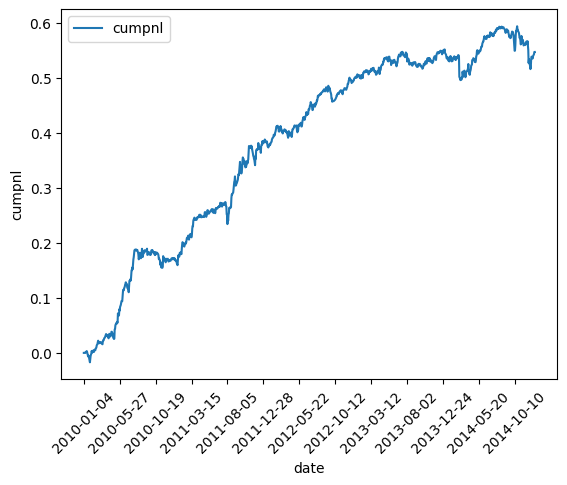

[0.17153272674624798, 0.3837789440431676, 0.4952046675107539, 0.5488982647991731, 0.5466361266412333]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,2.810019,0.640936,0.034603,0.171533
1,2011,2.868507,0.644960,0.040099,0.383779
2,2012,2.522248,0.637571,0.028996,0.495205
3,2013,1.203801,0.636768,0.030688,0.548898
4,2014,-0.030304,0.634479,0.077792,0.546636


In [154]:
alpha_1_data, alpha_1_cumpnl = AlphaStats(alpha_matrix1, close_df)
alpha_1_data.head()

In [155]:
test3(alpha_1_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


## The second strategy: Foma & French

$SMB - small minus big$

цена на маленькие компании растет быстрее, чем на большие,
сортируем акции по капитализации, больше капитализация - ставим в шорт,
меньше капитализация - в лонг.

Капитализация = кол-во акций (объем торгов) * цена акции

In [156]:
def make_SMB_alpha(close_df, volume_df, proportion=[33, 34, 33]):
    """
        Фама и Фенч предложили сортировать компании по капитализации, и выставлять соответственно
        лонг или шорт. Акции больших компаний растут медленнее, чем акции маленьких, поэтому
        на большие ставим шорт, на маленькие лонг, на среднечок ставим нули.

        Аргументы:
            close_df, pandas.DataFrame - кадр данных о ценах закрытия инструментов за каждый день
            volume_df, pandas.DataFrame - кадр данных об объемах торгов за каждый день
            proportion, 'list[int]' - пропорция по которой разделяются инструменты соответственно маленькие, средние и большие.
                                      по умолчанию принимает значение [33, 34, 33], что означает - разделить поровну.
                                      можно выбрать и другое соотношение, важно чтобы суммарно получалось 100(%).

        Возвращаемое значение:
            alpha_states_matrix, numpy.array - матрица состояний альфы на каждый день
    """
    
    def calc_capitalization(close_price, volume):
        """
            Calculates capitalization as a result of close prices and volume multiplication

            Arguments:
                close_price, numpy.array - an array of close prices with a size of (days, instruments_number)
                volume, numpy.array - an array of trading volume with a size of (days, instruments_number)

            Return value:
                capitalization, numpy.array - a matrix of instruments capitalization by days
        """
        return close_price * volume

    # checks if the sum of proportion elemts equals 100 %
    assert np.sum(proportion) == 100

    # get close and volume values
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T

    # get capitalization
    capitalization = calc_capitalization(close, volume)

    alpha = np.zeros(close.shape)
    true_false_vec = np.ones(close.shape)

    for i in range(close.shape[0]):

        indexes = np.argsort(capitalization[i])

        small_upper_border = round(len(indexes) * proportion[0] / 100)
        big_bottom_border = round(len(indexes) * (proportion[0] + proportion[1]) / 100)
    
        # get indexes
        small_indexes = indexes[:small_upper_border]
        middle_indexes = indexes[small_upper_border:big_bottom_border]
        big_indexes = indexes[big_bottom_border:]
        
        alpha[i][middle_indexes] = 0
        true_false_vec[i][middle_indexes] = 0
        alpha[i][big_indexes] *= 1

    alpha = normalize(neutralize_with_dropout(alpha, true_false_vec))
    
    return alpha

In [157]:
alpha_matrix2 = make_SMB_alpha(close_df, volume_df)

test1(alpha_matrix2)
test2(alpha_matrix2[1:])  # первый нулевой

Neutrality test passed
Normality test passed


/Users/hubievkasym/Desktop/Sirius Uni/DerivativesControl/helper.py:173: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = len(alpha_pnl_vec)**0.5 * alpha_pnl_vec.mean() / std


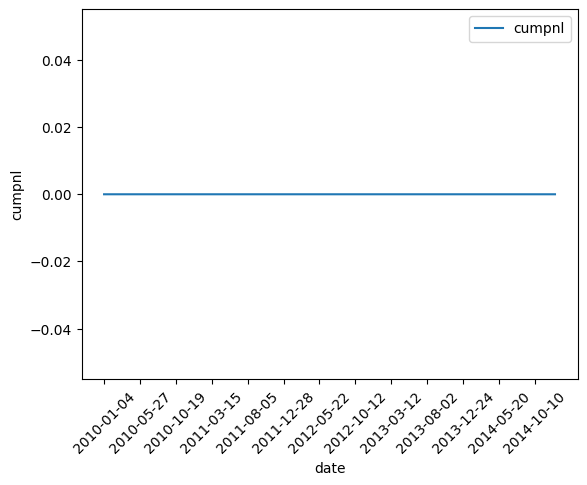

[0.0, 0.0, 0.0, 0.0, 0.0]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,NaN,0.0,0.0,0.0
1,2011,NaN,0.0,0.0,0.0
2,2012,NaN,0.0,0.0,0.0
3,2013,NaN,0.0,0.0,0.0
4,2014,NaN,0.0,0.0,0.0


In [158]:
alpha_2_data, alpha_2_cumpnl = AlphaStats(alpha_matrix2, close_df)
alpha_2_data.head()

In [159]:
test3(alpha_2_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


## The third strategy

$alpha = \frac{high-low}{close}$

In [160]:
day_step = 5

In [161]:
def make_high_minus_low_ratio_close_alpha(high_df, low_df, close_df, n):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros((close.shape))

    for i in range(n, close.shape[0]):
        alpha[i] = normalize(neutralize((high[i-n] - low[i-n]) / close[i-1]))

    return alpha

In [162]:
alpha_matrix3 = make_high_minus_low_ratio_close_alpha(high_df, low_df, close_df, day_step)
print(alpha_matrix3.shape)

(1257, 2436)


In [163]:
alpha_matrix3 = mpa.truncate_alpha(alpha_matrix3, 0.1)
# alpha_matrix3 = mpa.CutOutliers(alpha_matrix3, 2)
alpha_matrix3 = mpa.CutMiddle(alpha_matrix3, 7)
# alpha_matrix3 = np.concatenate((np.zeros((day_step, alpha_matrix3.shape[1])), alpha_matrix3))

In [164]:
alpha_matrix3 = normalize(decay(alpha_matrix3, 20))

In [165]:
test1(alpha_matrix3)
test2(alpha_matrix3[day_step:])

Neutrality test passed
Normality test passed


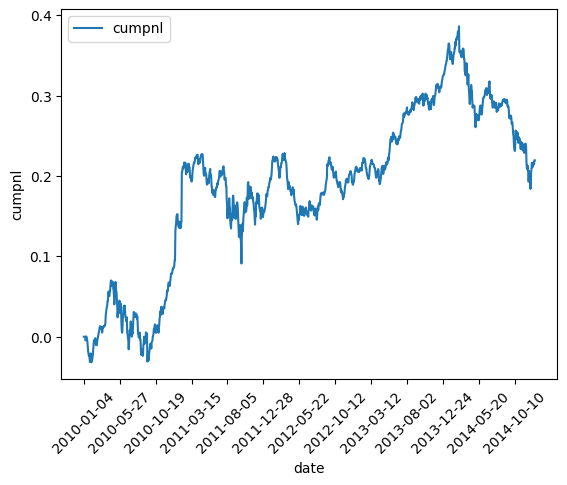

[0.08636356973293448, 0.1562045530220028, 0.19306034802604716, 0.32736835025665956, 0.21964680720924765]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.937589,0.129547,0.100924,0.086364
1,2011,0.533520,0.077392,0.136366,0.156205
2,2012,0.588038,0.075622,0.088572,0.193060
3,2013,2.533368,0.079733,0.032545,0.327368
4,2014,-1.177799,0.068012,0.202483,0.219647


In [166]:
alpha_3_data, alpha_3_cumpnl = AlphaStats(alpha_matrix3, close_df)
alpha_3_data.head()

In [167]:
test3(alpha_3_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


## The fourth strategy

**$alpha  = \frac{high}{low}$**

In [168]:
def make_high_low_ratio_alpha(high_df, low_df):
    
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T

    low = np.where(low == 0., 1e-12, low)

    alpha = np.zeros((high.shape))

    print(alpha.shape)

    for i in range(len(high)):
        alpha[i] = high[i-1] / low[i-1]

    alpha = normalize(neutralize(alpha))

    # alpha = np.concatenate((np.zeros((1, alpha.shape[1])), normalize(alpha[:-1])))
    return alpha

In [169]:
alpha_matrix4 = make_high_low_ratio_alpha(high_df, low_df)

(1257, 2436)


In [170]:
test1(alpha_matrix4)
test2(alpha_matrix4[1:])  # first is zero

Neutrality test passed
Normality test passed


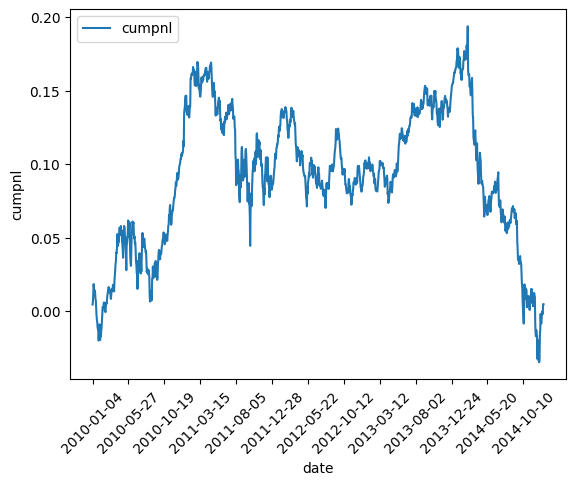

[0.10783870965098721, 0.08738886080106834, 0.08542639234464047, 0.15535401485984549, 0.0049642253171934825]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.466382,0.864689,0.055190,0.107839
1,2011,-0.206086,0.835975,0.125014,0.087389
2,2012,-0.035444,0.817876,0.068558,0.085426
3,2013,1.319687,0.833172,0.030989,0.155354
4,2014,-1.741582,0.752184,0.228383,0.004964


In [171]:
alpha_4_data, alpha_4_cumpnl = AlphaStats(alpha_matrix4, close_df)
alpha_4_data.head()

In [172]:
test3(alpha_4_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


## The fifth strategy

$alpha = (high + low - 2close) / close$

In [173]:
def make_alpha_the_fifth_way(high_df, low_df, close_df):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close = np.where(close == 0., 1e-14, close)

    alpha = np.zeros((high.shape))

    for i in range(1, len(high)):
        alpha[i] += normalize(neutralize((high[i-1] + low[i-1] - 2*close[i-1]) / close[i-1]))

    return alpha    

In [174]:
alpha_matrix5 = make_alpha_the_fifth_way(high_df, low_df, close_df)
alpha_matrix5 = mpa.decay(alpha_matrix5, 3)

test1(alpha_matrix5)
test2(alpha_matrix5[4:])  # first four are zero

Neutrality test passed
Normality test passed


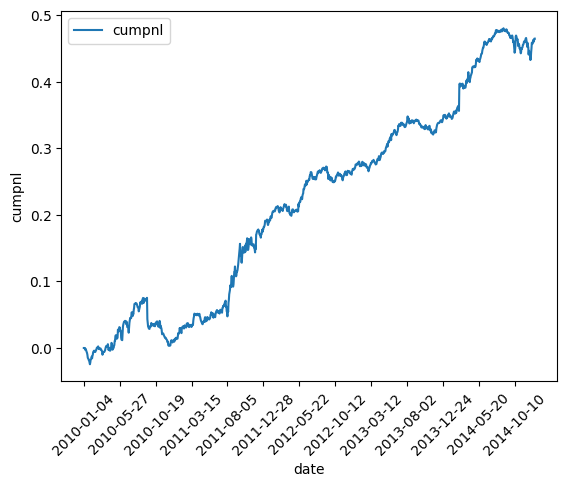

[0.011639331390950266, 0.18188586632740916, 0.267737682074576, 0.3482811538449449, 0.46473053804667325]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.202124,0.777200,0.071929,0.011639
1,2011,2.476531,0.783119,0.028386,0.181886
2,2012,2.216581,0.768793,0.023668,0.267738
3,2013,2.425754,0.773165,0.027287,0.348281
4,2014,1.869162,0.787636,0.047670,0.464731


In [175]:
alpha_5_data, alpha_5_cumpnl = AlphaStats(alpha_matrix5, close_df)
alpha_5_data.head()

In [176]:
test3(alpha_5_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


## The sixth strategy

$high \times low / close^2$

In [177]:
def make_sixth_strategy_alpha(high_df, low_df, close_df):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close = np.where(close == 0., 1e-14, close)

    alpha = neutralize(high * low / close**2)

    alpha = np.concatenate((np.zeros((1, alpha.shape[1])), normalize(alpha[:-1])))

    return alpha

In [178]:
alpha_matrix6 = make_sixth_strategy_alpha(high_df, low_df, close_df)
alpha_matrix6 = normalize(decay(alpha_matrix6, 7))

In [179]:
test1(alpha_matrix6)
test2(alpha_matrix6[1:]) # the first is zero

Neutrality test passed
Normality test passed


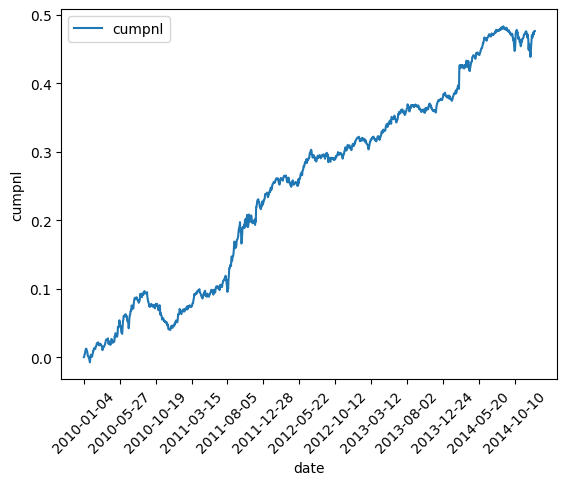

[0.04697971875300865, 0.2290685169522579, 0.30811742488996235, 0.38282974727095964, 0.4760750743782076]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.996861,0.576762,0.056718,0.046980
1,2011,2.765426,0.555449,0.031296,0.229069
2,2012,2.057764,0.538934,0.018225,0.308117
3,2013,2.260797,0.542927,0.018504,0.382830
4,2014,1.556845,0.557953,0.044734,0.476075


In [180]:
alpha_6_data, alpha_6_cumpnl = AlphaStats(alpha_matrix6, close_df)
alpha_6_data.head()

In [181]:
test3(alpha_6_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


# The seventh strategy

$alpha = (high + low) / close $ с каким множителем 1 или -1?

In [182]:
def make_high_low_close_ration_seventh_alpha(high_df, low_df, close_df, n):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    _new_alpha_matrix = np.zeros((close.shape))

    for i in range(n, len(close)):
        _new_alpha_matrix[i] = (high[i-n] + low[i-n]) / close[i-1]

    return normalize(neutralize(_new_alpha_matrix))

In [183]:
day_step = 1

alpha_matrix7 = make_high_low_close_ration_seventh_alpha(high_df, low_df, close_df, day_step)
alpha_matrix7 = normalize(decay(alpha_matrix7, 5))

test1(alpha_matrix7)
test2(alpha_matrix7[day_step:])

Neutrality test passed
Normality test passed


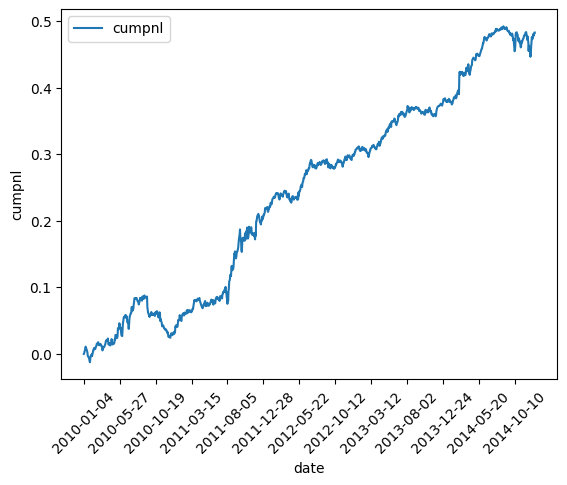

[0.03215280719807592, 0.20934157510514698, 0.29759743166178876, 0.3813295135982234, 0.48267353231210797]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.648975,0.656055,0.063462,0.032153
1,2011,2.626996,0.642099,0.033782,0.209342
2,2012,2.334990,0.626274,0.017852,0.297597
3,2013,2.586367,0.631040,0.016019,0.381330
4,2014,1.710148,0.644954,0.045789,0.482674


In [184]:
alpha_7_data, alpha_7_cumpnl = AlphaStats(alpha_matrix7, close_df)
alpha_7_data.head()

In [185]:
test3(alpha_7_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


# The eighth strategy

$alpha = open/close$

In [186]:
def make_open_close_ration_alpha(open_df, close_df):
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close = np.where(close == 0., 1e-14, close)  #  можно применить фильтр выбросов

    alpha = neutralize(open / close)

    alpha = np.concatenate((np.zeros((1, alpha.shape[1])), normalize(alpha[:-1])))

    return alpha

In [187]:
alpha_matrix8 = make_open_close_ration_alpha(open_df, close_df)
alpha_matrix8 = normalize(decay(alpha_matrix8, 4))

In [188]:
test1(alpha_matrix8)
test2(alpha_matrix8[1:])  # the first is zero

Neutrality test passed
Normality test passed


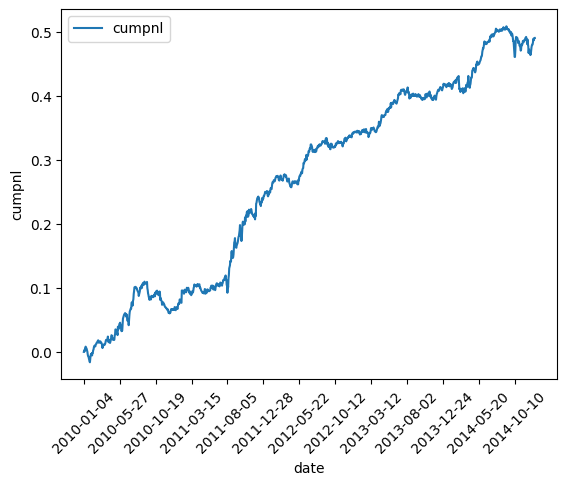

[0.06695983967491645, 0.24391530876609915, 0.34307096469614884, 0.41769577807363883, 0.4910560581775044]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.344467,0.735053,0.049632,0.066960
1,2011,2.668853,0.719520,0.027060,0.243915
2,2012,2.564729,0.715777,0.020296,0.343071
3,2013,2.044828,0.717484,0.019727,0.417696
4,2014,1.358026,0.728573,0.048019,0.491056


In [189]:
alpha_8_data, alpha_8_cumpnl = AlphaStats(alpha_matrix8, close_df)
alpha_8_data.head()

In [190]:
test3(alpha_8_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


# The ninth strategy

$alpha = high / close$

In [191]:
def make_high_close_ratio_alpha(high_df, close_df):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close = np.where(close == 0., 1e-14, close)  #  можно применить фильтр выбросов

    alpha = neutralize(high / close)

    alpha = np.concatenate((np.zeros((1, alpha.shape[1])), normalize(alpha[:-1])))

    return alpha

In [192]:
alpha_matrix9 = make_high_close_ratio_alpha(high_df, close_df)
alpha_matrix9 = normalize(decay(alpha_matrix9, 3))

In [193]:
test1(alpha_matrix9)
test2(alpha_matrix9[1:]) # the first is zero

Neutrality test passed
Normality test passed


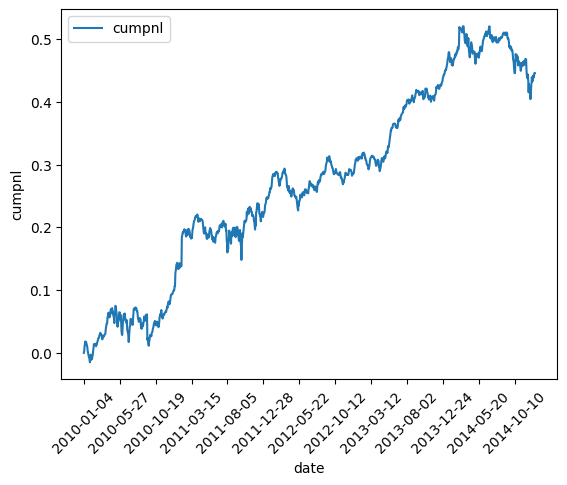

[0.0994472407754134, 0.223125665002396, 0.28643019752237525, 0.44324964943816386, 0.44575507714142804]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.210545,0.501521,0.063564,0.099447
1,2011,1.218826,0.480606,0.072204,0.223126
2,2012,1.244149,0.467210,0.066532,0.286430
3,2013,3.324478,0.471307,0.029569,0.443250
4,2014,0.029718,0.438402,0.116101,0.445755


In [194]:
alpha_9_data, alpha_9_cumpnl = AlphaStats(alpha_matrix9, close_df)
alpha_9_data.head()

In [195]:
test3(alpha_9_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


# The tenth strategy

$alpha = (close - low) / (high - low)$

In [214]:
def make_tenth_strategy_alpha(high_df, low_df, close_df):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close_min_low = close - low
    high_min_low = high - low
    high_min_low = np.where(high_min_low == 0.0, 1e-14, high_min_low)

    alpha = neutralize( - close_min_low / high_min_low)

    alpha = np.concatenate((np.zeros((1, alpha.shape[1])), normalize(alpha[:-1])))

    return alpha

In [215]:
alpha_matrix10 = make_tenth_strategy_alpha(high_df, low_df, close_df)

In [216]:
test1(alpha_matrix10)
test2(alpha_matrix10[1:]) # the first is null

Neutrality test passed
Normality test passed


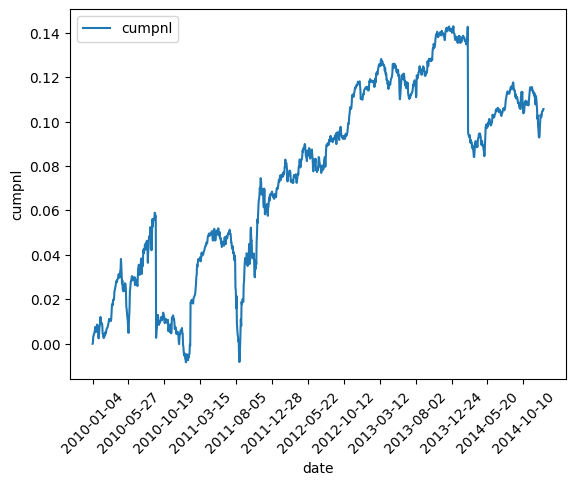

[0.004546366929331899, 0.06654502490069641, 0.10981393578483299, 0.14120436478413723, 0.10558799166862848]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.069740,1.314477,0.059115,0.004546
1,2011,1.221992,1.317017,0.060159,0.066545
2,2012,1.725020,1.296326,0.013001,0.109814
3,2013,1.328577,1.296003,0.018138,0.141204
4,2014,-0.667149,1.305958,0.058835,0.105588


In [217]:
alpha_10_data, alpha_10_cumpnl = AlphaStats(alpha_matrix10, close_df)
alpha_10_data.head()

In [218]:
test3(alpha_10_data)

Sharpe test passed
Turnover tets not passed
Cumpnl test not passed
passed 1 out of 3 tests


# The eleventh strategy

$alpha = (close - low) / (high - low) < 0.5$ Нужно решить какой знак

In [233]:
def make_alpha_eleventh(close_df, low_df, high_df):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close_min_low = close - low
    high_min_low = high - low
    high_min_low = np.where(high_min_low == 0.0, 1e-14, high_min_low)

    alpha = close_min_low / high_min_low
    alpha = neutralize(np.where(alpha < 0.5, alpha, 0))
    alpha = np.concatenate((np.zeros((1, alpha.shape[1])), normalize(alpha[:-1])))
    
    return alpha

In [234]:
alpha_matrix11 = make_alpha_eleventh(close_df, low_df, high_df)

test1(alpha_matrix11)
test2(alpha_matrix11[1:])

Neutrality test passed
Normality test passed


In [238]:
def count_instruments_volatility (instruments_incomes):
    
    def std (vector):
        return np.sqrt(np.sum((vector - vector.mean())**2) / (len(vector) - 1))

    # транспонируем матрицу доходностей, потому что сейчас каждая строка - это 
    # доходность каждого инструмента в конкретный день
    volatility = np.array([std(vector) for vector in instruments_incomes.T]) 

    return volatility

In [239]:
volatility_by_instrument = count_instruments_volatility(instruments_return(close_df))
print(volatility_by_instrument.shape)

indexes = np.argsort(volatility_by_instrument)
print(volatility_by_instrument[indexes][0:10])
plt.plot(np.arange(1, len(indexes)+1), volatility_by_instrument[indexes], label='sorted', color='red')
# plt.plot(volatility_by_instrument, label='not sorted', color='blue')
plt.legend()
plt.show()

NameError: name 'instruments_return' is not defined

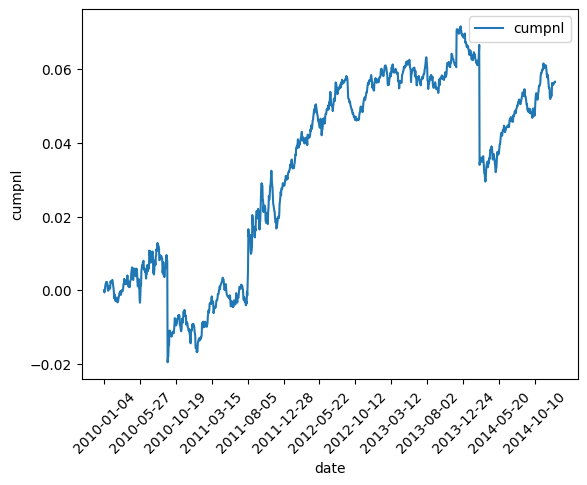

[-0.009756640707728399, 0.028322423249287576, 0.05409653537673177, 0.06896634909108187, 0.05648449994979292]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.287551,1.226154,0.032282,-0.009757
1,2011,1.549604,1.228256,0.015642,0.028322
2,2012,1.899955,1.212301,0.012063,0.054097
3,2013,0.891556,1.200160,0.009630,0.068966
4,2014,-0.353947,1.216536,0.040065,0.056484


In [235]:
alpha_11_data, alpha_11_cumpnl = AlphaStats(alpha_matrix11, close_df)
alpha_11_data.head()

In [236]:
test3(alpha_11_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


# The twelveth strategy
$alpha = ts\_correlation(volume, close)$

# проверка корреляции

## alpha1 = close(d-n)/close(d-1)

In [205]:
corr1_3 = calc_alphas_corr(alpha_1_cumpnl, alpha_3_cumpnl)
print(f'Корреляция между Альфа1 и Альфа3 =\t{corr1_3}')

corr1_4 = calc_alphas_corr(alpha_1_cumpnl, alpha_4_cumpnl)
print(f'Корреляция между Альфа1 и Альфа4 =\t{corr1_4}')

corr1_5 = calc_alphas_corr(alpha_1_cumpnl, alpha_5_cumpnl)
print(f'Корреляция между Альфа1 и Альфа5 =\t{corr1_5}')

corr1_6 = calc_alphas_corr(alpha_1_cumpnl, alpha_6_cumpnl)
print(f'Корреляция между Альфа1 и Альфа6 =\t{corr1_6}')

corr1_7 = calc_alphas_corr(alpha_1_cumpnl, alpha_7_cumpnl)
print(f'Корреляция между Альфа1 и Альфа7 =\t{corr1_7}')

corr1_8 = calc_alphas_corr(alpha_1_cumpnl, alpha_8_cumpnl)
print(f'Корреляция между Альфа1 и Альфа8 =\t{corr1_8}')

corr1_9 = calc_alphas_corr(alpha_1_cumpnl, alpha_9_cumpnl)
print(f'Корреляция между Альфа1 и Альфа9 =\t{corr1_9}')

corr1_10 = calc_alphas_corr(alpha_1_cumpnl, alpha_10_cumpnl)
print(f'Корреляция между Альфа1 и Альфа10 =\t{corr1_10}')

Корреляция между Альфа1 и Альфа3 =	0.8543964031041429
Корреляция между Альфа1 и Альфа4 =	0.29496094295238134
Корреляция между Альфа1 и Альфа5 =	0.942080946721929
Корреляция между Альфа1 и Альфа6 =	0.9628880888169413
Корреляция между Альфа1 и Альфа7 =	0.9541656320797379
Корреляция между Альфа1 и Альфа8 =	0.9733977492696012
Корреляция между Альфа1 и Альфа9 =	0.9337701487657551
Корреляция между Альфа1 и Альфа10 =	0.9337701487657551


In [206]:
corr3_4 = calc_alphas_corr(alpha_3_cumpnl, alpha_4_cumpnl)
print(f'Корреляция между Альфа3 и Альфа4 =\t{corr3_4}')

corr3_5 = calc_alphas_corr(alpha_3_cumpnl, alpha_5_cumpnl)
print(f'Корреляция между Альфа3 и Альфа5 =\t{corr3_5}')

corr3_6 = calc_alphas_corr(alpha_3_cumpnl, alpha_6_cumpnl)
print(f'Корреляция между Альфа3 и Альфа6 =\t{corr3_6}')

corr3_7 = calc_alphas_corr(alpha_3_cumpnl, alpha_7_cumpnl)
print(f'Корреляция между Альфа3 и Альфа7 =\t{corr3_7}')

corr3_8 = calc_alphas_corr(alpha_3_cumpnl, alpha_8_cumpnl)
print(f'Корреляция между Альфа3 и Альфа8 =\t{corr3_8}')

corr3_9 = calc_alphas_corr(alpha_3_cumpnl, alpha_9_cumpnl)
print(f'Корреляция между Альфа3 и Альфа9 =\t{corr3_9}')

corr3_10 = calc_alphas_corr(alpha_3_cumpnl, alpha_10_cumpnl)
print(f'Корреляция между Альфа3 и Альфа10 =\t{corr3_10}')

Корреляция между Альфа3 и Альфа4 =	0.6084483665213886
Корреляция между Альфа3 и Альфа5 =	0.7977406775047393
Корреляция между Альфа3 и Альфа6 =	0.821669246142499
Корреляция между Альфа3 и Альфа7 =	0.8150632325439995
Корреляция между Альфа3 и Альфа8 =	0.8250462778512515
Корреляция между Альфа3 и Альфа9 =	0.9365535333230233
Корреляция между Альфа3 и Альфа10 =	0.9365535333230233
